In [1]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers as L
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
base = ResNet50V2(False)

In [3]:
base.trainable = False
inputs = L.Input(shape=(224, 224, 3))
x = base(inputs, training=False)
x = L.GlobalAveragePooling2D()(x)
outputs = L.Dense(5)(x)

In [4]:
model = Model(inputs, outputs)

In [16]:
model.compile(Adam(learning_rate=1e-4), loss=CategoricalCrossentropy(from_logits=True), metrics=[CategoricalAccuracy()])

In [17]:
df = pd.read_csv('data/train.csv')
df = df[~df['path'].str.endswith('.gif')]
xtr, xts = train_test_split(df, stratify=df['class'], test_size=0.33)

In [18]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    vertical_flip=True, horizontal_flip=True, zoom_range=[0.5, 1.5],
    width_shift_range=[-100, 100], height_shift_range=[-100, 100]
)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

Found 258 non-validated image filenames belonging to 5 classes.
Found 128 non-validated image filenames belonging to 5 classes.
Epoch 1/200
2/9 [=====>........................] - ETA: 3s - loss: 0.2383 - categorical_accuracy: 0.9375 

/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


9/9 [==============================] - 11s 1s/step - loss: 0.4726 - categorical_accuracy: 0.8217 - val_loss: 0.1517 - val_categorical_accuracy: 0.9609
Epoch 2/200
9/9 [==============================] - 9s 976ms/step - loss: 0.4488 - categorical_accuracy: 0.8566 - val_loss: 0.1482 - val_categorical_accuracy: 0.9609
Epoch 3/200
9/9 [==============================] - 9s 1s/step - loss: 0.4523 - categorical_accuracy: 0.8333 - val_loss: 0.1467 - val_categorical_accuracy: 0.9609
Epoch 4/200
9/9 [==============================] - 9s 1s/step - loss: 0.4324 - categorical_accuracy: 0.8605 - val_loss: 0.1459 - val_categorical_accuracy: 0.9609
Epoch 5/200
9/9 [==============================] - 9s 1s/step - loss: 0.4064 - categorical_accuracy: 0.8760 - val_loss: 0.1443 - val_categorical_accuracy: 0.9609
Epoch 6/200
9/9 [==============================] - 9s 967ms/step - loss: 0.4466 - categorical_accuracy: 0.8372 - val_loss: 0.1451 - val_categorical_accuracy: 0.9609
Epoch 7/200
9/9 [================

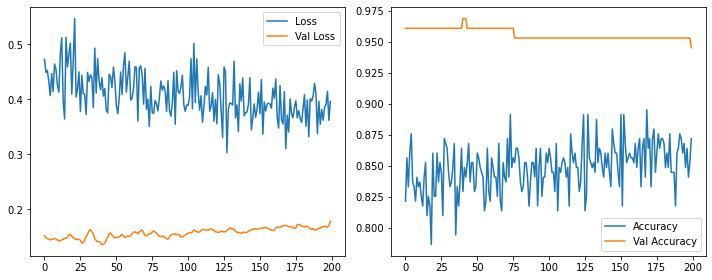

In [19]:
h = model.fit(
    train_gen.flow_from_dataframe(xtr, x_col='path', target_size=(224, 224), validate_filenames=False),
    validation_data=test_gen.flow_from_dataframe(xts, x_col='path', target_size=(224, 224), validate_filenames=False),
    epochs=200,
    # callbacks=[EarlyStopping(min_delta=0.01, patience=60, verbose=1)]
)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ax[0].plot(h.history['loss'], label='Loss')
ax[0].plot(h.history['val_loss'], label='Val Loss')
ax[1].plot(h.history['categorical_accuracy'], label='Accuracy')
ax[1].plot(h.history['val_categorical_accuracy'], label='Val Accuracy')
ax[0].legend()
ax[1].legend()
plt.tight_layout()

# LR Test

In [22]:
from sklearn.model_selection import StratifiedKFold

In [25]:
from tqdm import tqdm

In [60]:
lr = np.linspace(0, 0.01, 50)

accuracies = []
skf = StratifiedKFold(n_splits=4)
for _lr in tqdm(lr):
    model.compile(Adam(learning_rate=_lr), loss=CategoricalCrossentropy(from_logits=True), metrics=[CategoricalAccuracy()])
    folds = []
    for trix, tsix in skf.split(df, df['class']):
        xtr = df.iloc[trix]
        xts = df.iloc[tsix]
        traingen = ImageDataGenerator(
            preprocessing_function=preprocess_input,
            vertical_flip=True, horizontal_flip=True, zoom_range=[0.5, 1.5],
            width_shift_range=[-100, 100], height_shift_range=[-100, 100]
        ).flow_from_dataframe(xtr, x_col='path', target_size=(224, 224), validate_filenames=False)
        testgen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
            xts, x_col='path', target_size=(224, 224), validate_filenames=False
        )
        model.fit(traingen, verbose=0, epochs=10)
        p = model.predict(testgen).argmax(axis=1)
        ix2cls = {v: k for k, v in testgen.class_indices.items()}
        ypred = [ix2cls[pp] for pp in p]
        folds.append(accuracy_score(xts['class'], ypred))
    accuracies.append(folds)

  0%|          | 0/50 [00:00<?, ?it/s]

Found 289 non-validated image filenames belonging to 5 classes.
Found 97 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 289 non-validated image filenames belonging to 5 classes.
Found 97 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 290 non-validated image filenames belonging to 5 classes.
Found 96 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 290 non-validated image filenames belonging to 5 classes.
Found 96 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
  2%|▏         | 1/50 [04:59<4:04:21, 299.22s/it]

Found 289 non-validated image filenames belonging to 5 classes.
Found 97 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 289 non-validated image filenames belonging to 5 classes.
Found 97 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 290 non-validated image filenames belonging to 5 classes.
Found 96 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 290 non-validated image filenames belonging to 5 classes.
Found 96 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
  4%|▍         | 2/50 [09:58<3:59:24, 299.26s/it]

Found 289 non-validated image filenames belonging to 5 classes.
Found 97 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 289 non-validated image filenames belonging to 5 classes.
Found 97 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 290 non-validated image filenames belonging to 5 classes.
Found 96 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 290 non-validated image filenames belonging to 5 classes.
Found 96 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
  6%|▌         | 3/50 [14:56<3:54:01, 298.77s/it]

Found 289 non-validated image filenames belonging to 5 classes.
Found 97 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 289 non-validated image filenames belonging to 5 classes.
Found 97 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 290 non-validated image filenames belonging to 5 classes.
Found 96 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 290 non-validated image filenames belonging to 5 classes.
Found 96 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
  8%|▊         | 4/50 [19:51<3:47:53, 297.24s/it]

Found 289 non-validated image filenames belonging to 5 classes.
Found 97 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 289 non-validated image filenames belonging to 5 classes.
Found 97 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 290 non-validated image filenames belonging to 5 classes.
Found 96 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 290 non-validated image filenames belonging to 5 classes.
Found 96 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 10%|█         | 5/50 [24:50<3:43:27, 297.94s/it]

Found 289 non-validated image filenames belonging to 5 classes.
Found 97 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 289 non-validated image filenames belonging to 5 classes.
Found 97 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 290 non-validated image filenames belonging to 5 classes.
Found 96 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 290 non-validated image filenames belonging to 5 classes.
Found 96 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 12%|█▏        | 6/50 [29:47<3:38:11, 297.53s/it]

Found 289 non-validated image filenames belonging to 5 classes.
Found 97 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 289 non-validated image filenames belonging to 5 classes.
Found 97 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 290 non-validated image filenames belonging to 5 classes.
Found 96 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 290 non-validated image filenames belonging to 5 classes.
Found 96 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 14%|█▍        | 7/50 [34:43<3:32:46, 296.90s/it]

Found 289 non-validated image filenames belonging to 5 classes.
Found 97 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 289 non-validated image filenames belonging to 5 classes.
Found 97 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 290 non-validated image filenames belonging to 5 classes.
Found 96 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 290 non-validated image filenames belonging to 5 classes.
Found 96 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 16%|█▌        | 8/50 [39:41<3:28:10, 297.39s/it]

Found 289 non-validated image filenames belonging to 5 classes.
Found 97 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 289 non-validated image filenames belonging to 5 classes.
Found 97 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 290 non-validated image filenames belonging to 5 classes.
Found 96 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 290 non-validated image filenames belonging to 5 classes.
Found 96 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 18%|█▊        | 9/50 [44:38<3:23:02, 297.14s/it]

Found 289 non-validated image filenames belonging to 5 classes.
Found 97 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 289 non-validated image filenames belonging to 5 classes.
Found 97 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 290 non-validated image filenames belonging to 5 classes.
Found 96 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 290 non-validated image filenames belonging to 5 classes.
Found 96 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 20%|██        | 10/50 [49:36<3:18:15, 297.38s/it]

Found 289 non-validated image filenames belonging to 5 classes.
Found 97 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 289 non-validated image filenames belonging to 5 classes.
Found 97 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 290 non-validated image filenames belonging to 5 classes.
Found 96 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 290 non-validated image filenames belonging to 5 classes.
Found 96 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 22%|██▏       | 11/50 [54:35<3:13:42, 298.02s/it]

Found 289 non-validated image filenames belonging to 5 classes.
Found 97 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 289 non-validated image filenames belonging to 5 classes.
Found 97 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 290 non-validated image filenames belonging to 5 classes.
Found 96 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 290 non-validated image filenames belonging to 5 classes.
Found 96 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 24%|██▍       | 12/50 [59:33<3:08:44, 298.02s/it]

Found 289 non-validated image filenames belonging to 5 classes.
Found 97 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 289 non-validated image filenames belonging to 5 classes.
Found 97 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 290 non-validated image filenames belonging to 5 classes.
Found 96 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 290 non-validated image filenames belonging to 5 classes.
Found 96 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 26%|██▌       | 13/50 [1:04:29<3:03:19, 297.29s/it]

Found 289 non-validated image filenames belonging to 5 classes.
Found 97 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 289 non-validated image filenames belonging to 5 classes.
Found 97 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 290 non-validated image filenames belonging to 5 classes.
Found 96 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 290 non-validated image filenames belonging to 5 classes.
Found 96 non-validated image filenames belonging to 5 classes.


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 28%|██▊       | 14/50 [1:09:26<2:58:26, 297.40s/it]

Found 289 non-validated image filenames belonging to 5 classes.
Found 97 non-validated image filenames belonging to 5 classes.


 28%|██▊       | 14/50 [1:09:56<2:59:49, 299.72s/it]


KeyboardInterrupt: 

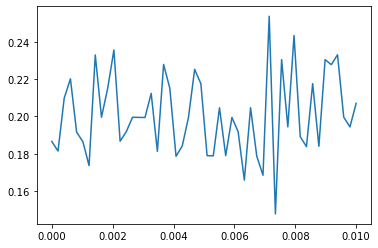

In [54]:
# A = np.array(accuracies)
plt.plot(lr, np.array(accuracies).mean(axis=1))

In [58]:
lr[np.mean(np.array(accuracies), axis=1).argmax()]

0.0071428571428571435